In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as T


In [5]:
plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            # ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [2]:
import tempfile
from pathlib import Path
from urllib.request import urlretrieve

video_url = "https://download.pytorch.org/tutorial/pexelscom_pavel_danilyuk_basketball_hd.mp4"
video_path = Path(tempfile.mkdtemp()) / "basketball.mp4"
vs = urlretrieve(video_url, video_path)

In [3]:
from torchvision.io import read_video

frames, _, _ = read_video(str(video_path))
print(frames.shape)

/usr/local/lib/python3.11/dist-packages/torchvision/io/video.py:197: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


torch.Size([333, 720, 1280, 3])


In [4]:
frames = frames.permute(0, 3, 1, 2)
print(frames.shape)

torch.Size([333, 3, 720, 1280])


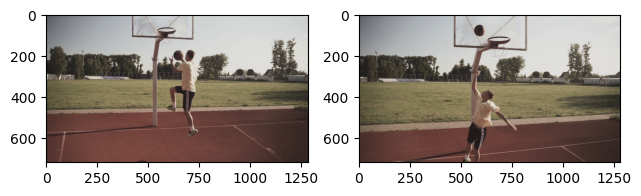

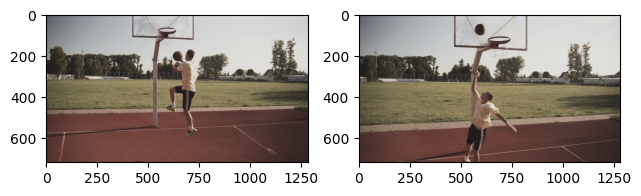

In [9]:
img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

plot(img1_batch)
plot(img2_batch)

In [16]:
def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
            T.Resize(size=(520, 960)),
        ]
    )
    batch = transforms(batch)
    return batch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img1_batch = preprocess(img1_batch).to(device)
img2_batch = preprocess(img2_batch).to(device)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 520, 960]), dtype = torch.float32


In [17]:
from torchvision.models.optical_flow import raft_large

weights = torchvision.models.optical_flow.Raft_Large_Weights
model = raft_large(weights=weights, progress=False).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
model.eval()

list_of_flows = model(img1_batch, img2_batch)
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

type = <class 'list'>
length = 12 = number of iterations of the model
